# Attempt 1

In [793]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [540]:
data = pd.read_csv('./2021_Competition_Training.csv')

/Users/vaibhavjha/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,8,9,11,13,16,20,26,28,29,31,33,51,55,58,62,64,66,68,75,85,102,124,127,131,132,135,160,174,180,187,192,202,209,210,211,215,220,230,234,240,243,247,251,255,261,285,293,297,300,305,306,309,323,334,344,345,352,353,355,359) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [541]:
data_100k = data.sample(n=100000, random_state=42)
data_100k.drop(columns=[data_100k.columns[0]], inplace=True)
X = data_100k.drop(columns=['covid_vaccination'])
y = data_100k.loc[:,'covid_vaccination'].astype('category').cat.codes

In [798]:
# data.drop(columns=[data.columns[0]], inplace=True)

# X = data.drop(columns=['covid_vaccination'])
# y = data.loc[:,'covid_vaccination'].astype('category').cat.codes

In [799]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)


## Utilities

In [543]:
data_dict = pd.read_csv('/Users/vaibhavjha/Downloads/data_dict_hum - Data Dictionary.csv')

In [544]:
data_dict.set_index('Features', inplace=True)

In [545]:
def whatis(colname):
    return data_dict.loc[colname][0]

In [546]:
def get_feature_correlation(df, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True):
    """
    Compute the feature correlation and sort feature pairs based on their correlation

    :param df: The dataframe with the predictor variables
    :type df: pandas.core.frame.DataFrame
    :param top_n: Top N feature pairs to be reported (if None, all of the pairs will be returned)
    :param corr_method: Correlation compuation method
    :type corr_method: str
    :param remove_duplicates: Indicates whether duplicate features must be removed
    :type remove_duplicates: bool
    :param remove_self_correlations: Indicates whether self correlations will be removed
    :type remove_self_correlations: bool

    :return: pandas.core.frame.DataFrame
    """
    corr_matrix_abs = df.corr(method=corr_method).abs()
    corr_matrix_abs_us = corr_matrix_abs.unstack()
    sorted_correlated_features = corr_matrix_abs_us \
        .sort_values(kind="quicksort", ascending=False) \
        .reset_index()

    # Remove comparisons of the same feature
    if remove_self_correlations:
        sorted_correlated_features = sorted_correlated_features[
            (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
        ]

    # Remove duplicates
    if remove_duplicates:
        sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

    # Create meaningful names for the columns
    sorted_correlated_features.columns = ['Feature 1', 'Feature 2', 'Correlation (abs)'] 

    if top_n:
        return sorted_correlated_features[:top_n]

    return sorted_correlated_features

## Working on the numeric columns

In [547]:
# # Extract numeric columns
# X_train_num = X_train.select_dtypes(['number']).copy()
# X_cols = X_train_num.columns
# len(X_cols)

In [800]:
X_train_num = X_train.replace('*', np.nan)
X_train_num = X_train_num.apply(pd.to_numeric, errors='ignore').select_dtypes(['number']).copy()
X_cols = X_train_num.columns
len(X_cols)

313

In [801]:
# drop rows with more than 20% null values
na_threshold = int(len(X_train_num.columns) * 0.95)
print(f'atleast {na_threshold} non-null cols')
X_train_num = X_train_num.dropna(thresh=na_threshold)

atleast 297 non-null cols


In [802]:
X_train_num.shape

(532731, 313)

In [803]:
y_train = y_train[X_train_num.index]

In [804]:
# Inspect NaN
inspection_cols = {}
nan_cols = (X_train_num.isna().sum() / len(X_train_num)).sort_values()
nan_cols_th = nan_cols[nan_cols > 0.075]
inspection_cols['nan_numeric_cols'] = list(zip(nan_cols_th.index, nan_cols_th.values))

In [805]:
# Look at these columns
inspection_cols

{'nan_numeric_cols': [('atlas_pct_fmrkt_credit16', 0.08031445513777122),
  ('atlas_pct_fmrkt_otherfood16', 0.08035950601710808),
  ('atlas_pct_fmrkt_wic16', 0.08035950601710808),
  ('atlas_pct_fmrkt_snap16', 0.08036889161696992),
  ('atlas_pct_fmrkt_wiccash16', 0.08036889161696992),
  ('atlas_pct_fmrkt_sfmnp16', 0.08038578569672124),
  ('atlas_pct_fmrkt_anmlprod16', 0.0803876628166936),
  ('atlas_pct_fmrkt_baked16', 0.08044397641586466),
  ('atlas_pct_fmrkt_frveg16', 0.0804477306558094),
  ('atlas_pc_wic_redemp12', 0.11143522715967345),
  ('cons_ltmedicr', 0.14273432557895072),
  ('bh_ip_snf_mbr_resp_pmpm_cost_9to12m_b4', 0.1437216906844167),
  ('total_physician_office_net_paid_pmpm_cost_9to12m_b4', 0.14372732204433383),
  ('total_med_allowed_pmpm_cost_9to12m_b4', 0.14378551276347726),
  ('bh_ip_snf_net_paid_pmpm_cost_9to12m_b4', 0.14430172075587866),
  ('atlas_agritrsm_rct12', 0.23898177504218826),
  ('atlas_berry_acrespth12', 0.2507043892696314),
  ('atlas_ghveg_sqftpth12', 0.2639756

In [806]:
cols_to_desc = []
for col in inspection_cols['nan_numeric_cols']:
    print(f'{col[0]} - {whatis(col[0])}\n')
    cols_to_desc.append(col[0])

atlas_pct_fmrkt_credit16 - Farmers’ markets that report accepting credit cards

atlas_pct_fmrkt_otherfood16 - Farmers’ markets that report selling other food products

atlas_pct_fmrkt_wic16 - Farmers’ markets that report accepting WIC

atlas_pct_fmrkt_snap16 - Farmers’ markets that report accepting SNAP

atlas_pct_fmrkt_wiccash16 - Farmers’ markets that report accepting WIC Cash

atlas_pct_fmrkt_sfmnp16 - Farmers’ markets that report accepting SFMNP

atlas_pct_fmrkt_anmlprod16 - Farmers' markets that report selling animal products

atlas_pct_fmrkt_baked16 - Farmersâ€™ markets that report selling baked/prepared food products

atlas_pct_fmrkt_frveg16 - Farmers’ markets that report selling fruit & vegetables

atlas_pc_wic_redemp12 - WIC redemptions per capita

cons_ltmedicr - Late to Medicare Index

bh_ip_snf_mbr_resp_pmpm_cost_9to12m_b4 - member responsibility cost per month for behavioral health claims related to skilled nursing inpatient facilities in the past ninth to twelfth month pr

In [807]:
X_train_num_imputed = X_train_num.fillna(X_train_num.median())

In [808]:
X_train_num_imputed

,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,src_div_id,...,atlas_pct_fmrkt_otherfood16,auth_3mth_post_acute_end,auth_3mth_acute_mus,atlas_perpov_1980_0711,atlas_pct_laccess_white15,auth_3mth_post_acute_mean_los,rx_gpi2_66_pmpm_ct,auth_3mth_acute_gus,atlas_low_education_2015_update,race_cd
37363,0.0,0.000000,10.279676,0.126450,83.000000,45.054878,0.0,0.0,0.0,0.0,...,80.000000,0,0.0,0.0,13.463036,0.0,0.000000,0,0.0,1.0
840972,0.0,0.000000,4.351367,0.077003,50.000000,57.335294,0.0,0.0,0.0,1.0,...,50.000000,0,0.0,0.0,10.095356,0.0,0.000000,0,1.0,1.0
407594,0.0,8.700000,2.881606,0.097901,55.555556,54.204627,0.0,0.0,0.0,0.0,...,55.555556,0,0.0,0.0,6.473853,0.0,0.083333,0,0.0,5.0
478326,0.0,31.540000,4.590493,0.130367,100.000000,56.132519,0.0,0.0,0.0,0.0,...,100.000000,0,0.0,0.0,11.335864,0.0,0.000000,0,0.0,1.0
22923,0.0,0.000000,2.341948,0.105838,100.000000,22.040377,0.0,0.0,0.0,0.0,...,100.000000,0,0.0,0.0,13.520798,0.0,0.000000,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36482,0.0,32.600000,4.676873,0.084274,100.000000,42.884929,0.0,0.0,0.0,0.0,...,100.000000,0,0.0,0.0,10.772253,0.0,0.000000,0,0.0,3.0
564465,0.0,0.000000,0.836858,0.226709,100.000000,37.037529,0.0,0.0,0.0,0.0,...,100.000000,0,0.0,0.0,6.092744,0.0,0.166667,0,0.0,1.0
412925,0.0,19.899999,5.178283,0.136370,50.000000,47.391187,0.0,0.0,0.0,0.0,...,50.000000,0,0.0,0.0,15.516156,0.0,0.000000,0,0.0,1.0
759451,0.0,0.000000,3.135291,0.236357,0.000000,40.487959,0.0,0.0,0.0,0.0,...,0.000000,0,0.0,0.0,10.857713,0.0,0.000000,0,0.0,1.0


### Scaling Values and Getting top columns

In [809]:
# Scale the numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_num_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_num_imputed),
                                          index = X_train_num_imputed.index,
                                          columns = X_train_num_imputed.columns)

In [810]:
X_train_num_imputed_scaled

,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,src_div_id,...,atlas_pct_fmrkt_otherfood16,auth_3mth_post_acute_end,auth_3mth_acute_mus,atlas_perpov_1980_0711,atlas_pct_laccess_white15,auth_3mth_post_acute_mean_los,rx_gpi2_66_pmpm_ct,auth_3mth_acute_gus,atlas_low_education_2015_update,race_cd
37363,0.0,-0.063351,1.968939,0.733435,0.629409,-0.075615,0.0,0.0,-0.057889,-0.278874,...,0.682387,0.0,-0.005126,-0.201055,-0.187516,-0.043838,-0.326102,-0.005306,-0.263173,-0.241458
840972,0.0,-0.063351,-0.242415,-0.299464,-0.477206,0.717950,0.0,0.0,-0.057889,2.548081,...,-0.247999,0.0,-0.005126,-0.201055,-0.581121,-0.043838,-0.326102,-0.005306,3.799782,-0.241458
407594,0.0,0.067620,-0.790659,0.137074,-0.290907,0.515645,0.0,0.0,-0.057889,-0.278874,...,-0.075705,0.0,-0.005126,-0.201055,-1.004393,-0.043838,0.219450,-0.005306,-0.263173,6.344856
478326,0.0,0.411456,-0.153217,0.815255,1.199483,0.640226,0.0,0.0,-0.057889,-0.278874,...,1.302644,0.0,-0.005126,-0.201055,-0.436134,-0.043838,-0.326102,-0.005306,-0.263173,-0.241458
22923,0.0,-0.063351,-0.991960,0.302865,1.199483,-1.562821,0.0,0.0,-0.057889,-0.278874,...,1.302644,0.0,-0.005126,-0.201055,-0.180765,-0.043838,-0.326102,-0.005306,-0.263173,-0.241458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36482,0.0,0.427414,-0.120996,-0.147588,1.199483,-0.215838,0.0,0.0,-0.057889,-0.278874,...,1.302644,0.0,-0.005126,-0.201055,-0.502007,-0.043838,-0.326102,-0.005306,-0.263173,3.051699
564465,0.0,-0.063351,-1.553382,2.827768,1.199483,-0.593700,0.0,0.0,-0.057889,-0.278874,...,1.302644,0.0,-0.005126,-0.201055,-1.048936,-0.043838,0.765003,-0.005306,-0.263173,-0.241458
412925,0.0,0.236226,0.066038,0.940660,-0.477206,0.075358,0.0,0.0,-0.057889,-0.278874,...,-0.247999,0.0,-0.005126,-0.201055,0.052448,-0.043838,-0.326102,-0.005306,-0.263173,-0.241458
759451,0.0,-0.063351,-0.696030,3.029317,-2.153896,-0.370731,0.0,0.0,-0.057889,-0.278874,...,-1.798642,0.0,-0.005126,-0.201055,-0.492019,-0.043838,-0.326102,-0.005306,-0.263173,-0.241458


In [811]:
# Detect and remove multicollinearity

multicollinearity = get_feature_correlation(X_train_num_imputed_scaled)
mc_above80 = multicollinearity[multicollinearity['Correlation (abs)'] > 0.80]
mc_above80

,Feature 1,Feature 2,Correlation (abs)
259,rx_gpi4_3400_pmpm_ct,rx_gpi2_34_pmpm_ct,0.984650
261,rx_gpi2_72_pmpm_ct_6to9m_b4,rx_gpi2_72_pmpm_cost_6to9m_b4,0.983054
263,auth_3mth_bh_acute,auth_3mth_psychic,0.979492
265,rx_gpi2_34_pmpm_ct,rx_gpi2_34_dist_gpi6_pmpm_ct,0.977359
267,auth_3mth_acute_mean_los,auth_3mth_acute,0.976066
269,rx_gpi4_3400_pmpm_ct,rx_gpi2_34_dist_gpi6_pmpm_ct,0.974643
271,bh_ncdm_ind,bh_ncdm_pct,0.971624
273,rx_overall_gpi_pmpm_ct_0to3m_b4,rx_generic_pmpm_ct_0to3m_b4,0.964576
275,rx_nonbh_mbr_resp_pmpm_cost,rx_overall_mbr_resp_pmpm_cost,0.958481
277,bh_ncal_pmpm_ct,bh_ncal_ind,0.956502


In [812]:
common_sets = []
for key, value in mc_above80.to_dict('index').items():
    exists_already = False
    v1, v2 = value['Feature 1'], value['Feature 2']
    for s in common_sets:
        if v1 in s or v2 in s:
            s.add(v1)
            s.add(v2)
            exists_already = True
    if not exists_already:
        common_sets.append(set([v1,v2]))


In [813]:
common_sets

[{'rx_gpi2_34_dist_gpi6_pmpm_ct',
  'rx_gpi2_34_pmpm_ct',
  'rx_gpi4_3400_pmpm_ct'},
 {'rx_gpi2_72_pmpm_cost_6to9m_b4', 'rx_gpi2_72_pmpm_ct_6to9m_b4'},
 {'auth_3mth_bh_acute', 'auth_3mth_psychic'},
 {'auth_3mth_acute',
  'auth_3mth_acute_mean_los',
  'auth_3mth_dc_home',
  'auth_3mth_home',
  'auth_3mth_post_er'},
 {'bh_ncdm_ind', 'bh_ncdm_pct'},
 {'rx_generic_pmpm_ct_0to3m_b4',
  'rx_nonbh_pmpm_ct_0to3m_b4',
  'rx_nonotc_dist_gpi6_pmpm_ct',
  'rx_overall_gpi_pmpm_ct_0to3m_b4'},
 {'rx_generic_mbr_resp_pmpm_cost',
  'rx_generic_mbr_resp_pmpm_cost_0to3m_b4',
  'rx_nonbh_mbr_resp_pmpm_cost',
  'rx_nonbh_mbr_resp_pmpm_cost_6to9m_b4',
  'rx_overall_mbr_resp_pmpm_cost',
  'rx_overall_mbr_resp_pmpm_cost_0to3m_b4'},
 {'bh_ncal_ind', 'bh_ncal_pct', 'bh_ncal_pmpm_ct'},
 {'auth_3mth_post_acute',
  'auth_3mth_post_acute_mean_los',
  'auth_3mth_snf_post_hsp'},
 {'atlas_foodinsec_13_15', 'atlas_vlfoodsec_13_15'},
 {'ccsp_227_pct', 'phy_em_px_pct'},
 {'credit_bal_nonmtgcredit_60dpd',
  'credit_hh_ban

In [815]:
# 47 redundant columns
import itertools
remove_cols = [ list(i)[:-1] for i in common_sets]
remove_cols = list(itertools.chain(*remove_cols))
len(remove_cols)

47

In [816]:
X_train_num_imputed_scaled.drop(axis=1, columns=remove_cols, inplace=True)

In [817]:
X_train_num_imputed_scaled.shape

(532731, 275)

## Finding the best categorical columns

In [818]:
# Extract categorical columns
X_train_cat = X_train.replace('*', np.nan)
X_train_cat = X_train_cat.select_dtypes(['object']).copy()
X_cols_cat = X_train_cat.columns
X_cols_cat

Index(['ID', 'auth_3mth_post_acute_dia',
       'bh_ip_snf_net_paid_pmpm_cost_9to12m_b4', 'auth_3mth_acute_ckd',
       'src_div_id', 'total_bh_copay_pmpm_cost_t_9-6-3m_b4',
       'bh_ip_snf_net_paid_pmpm_cost_3to6m_b4', 'mcc_ano_pmpm_ct_t_9-6-3m_b4',
       'auth_3mth_post_acute_trm', 'rx_maint_pmpm_cost_t_12-9-6m_b4',
       ...
       'rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4', 'auth_3mth_post_er',
       'total_physician_office_visit_ct_pmpm_t_6-3-0m_b4',
       'rx_gpi2_33_pmpm_ct_0to3m_b4', 'auth_3mth_post_acute_chf',
       'auth_3mth_dc_other', 'auth_3mth_bh_acute_mean_los',
       'auth_3mth_post_acute_gus', 'auth_3mth_acute_mus',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4'],
      dtype='object', length=114)

In [819]:
# Detect numerical ones from the 114 columns
numeric_cols = X_train_cat.apply(pd.to_numeric, errors='coerce')
numeric_cols.dropna(axis=1, inplace=True, thresh=(0.75 * X_train_cat.shape[0]))
len(numeric_cols.columns)

61

In [820]:
# Remove numeric columns
X_train_cat.drop(columns=numeric_cols.columns, inplace=True)

In [821]:
# Column-wise categorical count
cat_dict = {}
for col in X_train_cat.columns:
    cat_dict[col] = X_train_cat[col].unique()
cat_dict

{'ID': array(['acfM5OSaT788eL33b5YAad5I', 'bfM73O97eSc7TL913Y4AI2bb',
        '73Md7eO2S8abT94LY29A7Ibd', ..., '20203M6Oa8S599TL0cYaeA2I',
        'ea799M2O3STL9YAIfc3e88df', 'ebdMO4Sf73TL12a2187Yc0AI'],
       dtype=object),
 'total_bh_copay_pmpm_cost_t_9-6-3m_b4': array(['No Activity', 'No_Change', 'New', 'Resolved', 'Dec_over_8x',
        'Inc_2x-4x', 'Dec_1x-2x', 'Dec_2x-4x', 'Inc_1x-2x', 'Dec_4x-8x',
        'Inc_over_8x', 'Inc_4x-8x'], dtype=object),
 'mcc_ano_pmpm_ct_t_9-6-3m_b4': array(['No Activity', 'New', 'Resolved', 'No_Change', 'Dec_2x-4x',
        'Dec_1x-2x', 'Inc_1x-2x', nan], dtype=object),
 'rx_maint_pmpm_cost_t_12-9-6m_b4': array(['No_Change', 'No Activity', 'Inc_4x-8x', 'Dec_1x-2x', 'Inc_1x-2x',
        'New', 'Inc_2x-4x', 'Dec_2x-4x', 'Dec_4x-8x', 'Resolved',
        'Dec_over_8x', 'Inc_over_8x'], dtype=object),
 'rx_nonbh_pmpm_cost_t_9-6-3m_b4': array(['No_Change', 'No Activity', 'Dec_2x-4x', 'New', 'Inc_1x-2x',
        'Dec_1x-2x', 'Inc_2x-4x', 'Resolved', 'Dec_o

In [822]:
# drop rows with more than 20% null values
na_threshold = int(len(X_train_cat.columns) * 0.95)
print(f'atleast {na_threshold} non-null cols')
X_train_cat = X_train_cat.dropna(thresh=na_threshold)

atleast 50 non-null cols


#### Analyze categorical variables

In [823]:
sorted_cat_dict = dict(sorted(cat_dict.items(), key= lambda x: len(x[1])))
for key, value in sorted_cat_dict.items():
    print(f'{key} ==> {len(value)}')

rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4 ==> 2
rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4 ==> 2
total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4 ==> 2
sex_cd ==> 2
bh_urgent_care_copay_pmpm_cost_t_12-9-6m_b4 ==> 3
hedis_dia_hba1c_ge9 ==> 3
bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4 ==> 3
cons_mobplus ==> 5
med_ambulance_coins_pmpm_cost_t_9-6-3m_b4 ==> 6
mcc_ano_pmpm_ct_t_9-6-3m_b4 ==> 8
lang_spoken_cd ==> 8
rx_gpi2_17_pmpm_cost_t_12-9-6m_b4 ==> 10
rej_med_outpatient_visit_ct_pmpm_t_6-3-0m_b4 ==> 11
med_outpatient_deduct_pmpm_cost_t_9-6-3m_b4 ==> 11
total_bh_copay_pmpm_cost_t_9-6-3m_b4 ==> 12
rx_maint_pmpm_cost_t_12-9-6m_b4 ==> 12
rx_nonbh_pmpm_cost_t_9-6-3m_b4 ==> 12
rx_generic_pmpm_cost_t_6-3-0m_b4 ==> 12
rx_overall_mbr_resp_pmpm_cost_t_6-3-0m_b4 ==> 12
rx_overall_dist_gpi6_pmpm_ct_t_6-3-0m_b4 ==> 12
rx_phar_cat_humana_pmpm_ct_t_9-6-3m_b4 ==> 12
rx_overall_gpi_pmpm_ct_t_6-3-0m_b4 ==> 12
mcc_chf_pmpm_ct_t_9-6-3m_b4 ==> 12
rx_maint_pmpm_cost_t_6-3-0m_b4 ==> 12
rx_maint_net_paid_pmpm_cost_

In [824]:
X_train_cat.shape

(597531, 53)

In [825]:
# Drop ID
X_train_cat.drop(columns=['ID'], inplace=True)

In [826]:
X_train_cat.isna().sum().sort_values().tail(8)

med_outpatient_deduct_pmpm_cost_t_9-6-3m_b4             43
total_physician_office_visit_ct_pmpm_t_6-3-0m_b4        61
rej_med_outpatient_visit_ct_pmpm_t_6-3-0m_b4            97
cons_mobplus                                         54764
cons_hhcomp                                          54793
hedis_dia_hba1c_ge9                                 170021
mabh_seg                                            360167
lang_spoken_cd                                      430644
dtype: int64

In [827]:
missing = ['lang_spoken_cd', 'mabh_seg', 'hedis_dia_hba1c_ge9', 'cons_hhcomp', 'cons_mobplus']
for var in missing:
    print(X_train_cat[var].value_counts())

ENG    154779
SPA     10963
OTH       583
CHI       231
VIE       121
KOR       117
CRE        93
Name: lang_spoken_cd, dtype: int64
H6    59875
H2    50696
H7    23752
H1    23671
C5    19179
C4    17824
C2    13633
H4    13324
H5     3285
H8     3148
H3     2891
C6     2005
C3     1998
C7     1227
C1      856
Name: mabh_seg, dtype: int64
N    421878
Y      5632
Name: hedis_dia_hba1c_ge9, dtype: int64
B    195257
L     92255
A     82920
J     55685
U     51466
D     14546
H     10667
G      8203
F      7515
C      7378
K      7207
E      5086
I      4553
Name: cons_hhcomp, dtype: int64
M    319280
S    157537
U     46350
P     19600
Name: cons_mobplus, dtype: int64


In [828]:
# Removing lang_spoken_cd
X_train_cat.drop(columns=['lang_spoken_cd'], inplace=True)

In [829]:
X_train_cat.columns

Index(['total_bh_copay_pmpm_cost_t_9-6-3m_b4', 'mcc_ano_pmpm_ct_t_9-6-3m_b4',
       'rx_maint_pmpm_cost_t_12-9-6m_b4', 'rx_nonbh_pmpm_cost_t_9-6-3m_b4',
       'rx_gpi2_17_pmpm_cost_t_12-9-6m_b4', 'rx_generic_pmpm_cost_t_6-3-0m_b4',
       'rx_overall_mbr_resp_pmpm_cost_t_6-3-0m_b4',
       'rx_overall_dist_gpi6_pmpm_ct_t_6-3-0m_b4',
       'rx_phar_cat_humana_pmpm_ct_t_9-6-3m_b4',
       'rx_overall_gpi_pmpm_ct_t_6-3-0m_b4', 'mcc_chf_pmpm_ct_t_9-6-3m_b4',
       'bh_urgent_care_copay_pmpm_cost_t_12-9-6m_b4',
       'rx_maint_pmpm_cost_t_6-3-0m_b4', 'cons_mobplus',
       'rx_maint_net_paid_pmpm_cost_t_12-9-6m_b4',
       'rej_med_outpatient_visit_ct_pmpm_t_6-3-0m_b4',
       'rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4',
       'med_physician_office_allowed_pmpm_cost_t_9-6-3m_b4',
       'total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4',
       'rx_branded_pmpm_ct_t_6-3-0m_b4',
       'med_outpatient_deduct_pmpm_cost_t_9-6-3m_b4',
       'total_allowed_pmpm_cost_t_9-6-3m_b4', 'm

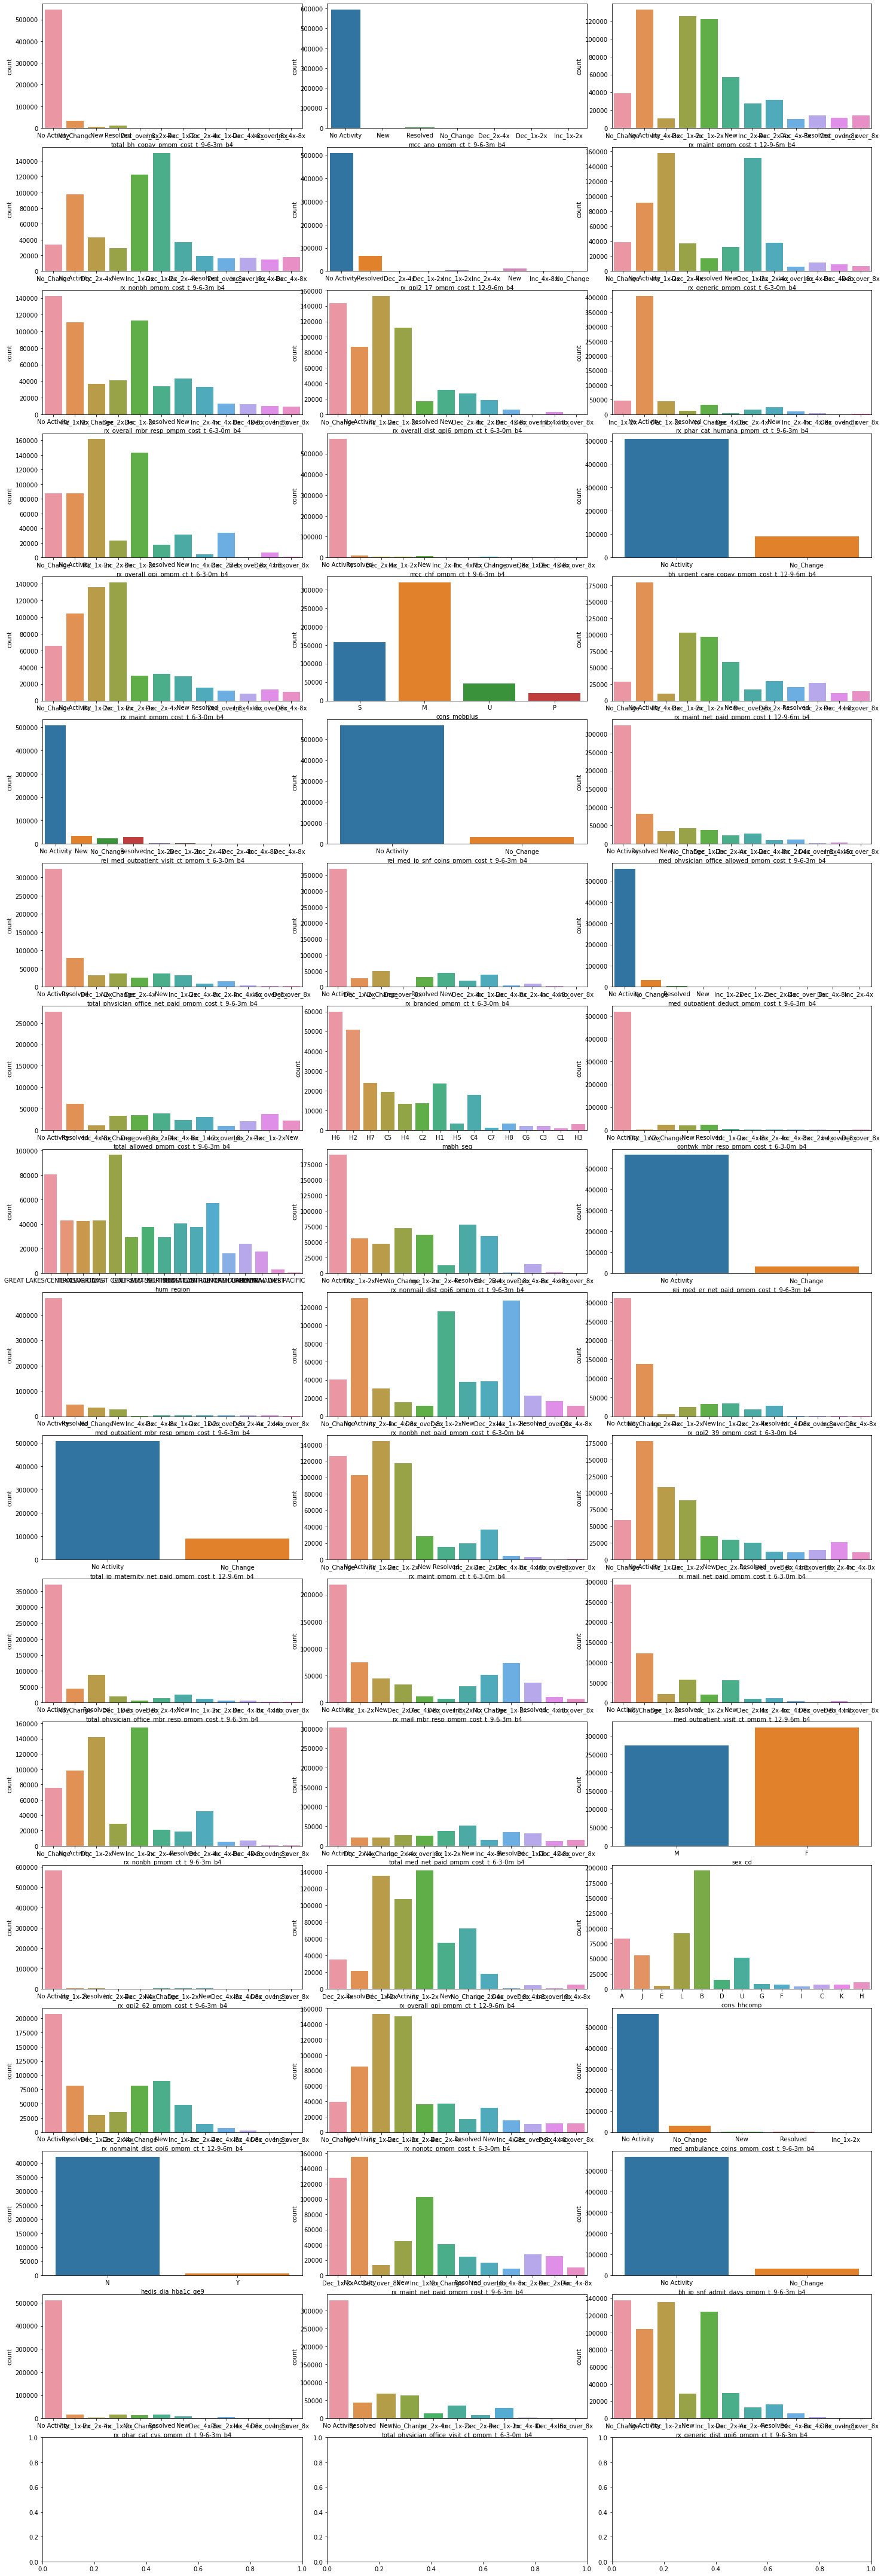

In [830]:
# Plot graphs for each categorical variable
fig, axes = plt.subplots(18,3, figsize=(20,60))
fig.tight_layout()
i = j = counter = 0
for col in X_train_cat.columns:
    
    sns.countplot(data=X_train_cat, x=col, ax=axes[i][j])
    j += 1
    if j > 2:
        i += 1
        j = 0
    
plt.show()

In [831]:
X_train_cat_dummified = pd.get_dummies(X_train_cat, prefix=X_train_cat.columns, drop_first=True)

In [ ]:
# Detect and remove multicollinearity

multicollinearity = get_feature_correlation(X_train_cat_dummified)
mc_above80 = multicollinearity[multicollinearity['Correlation (abs)'] > 0.80]
mc_above80

In [ ]:
common_sets = []
for key, value in mc_above80.to_dict('index').items():
    exists_already = False
    v1, v2 = value['Feature 1'], value['Feature 2']
    for s in common_sets:
        if v1 in s or v2 in s:
            s.add(v1)
            s.add(v2)
            exists_already = True
    if not exists_already:
        common_sets.append(set([v1,v2]))

In [ ]:
common_sets

In [626]:
# 63 redundant columns
import itertools
remove_cols = [ list(i)[:-1] for i in common_sets]
remove_cols = list(itertools.chain(*remove_cols))
remove_cols

['rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4_No_Change',
 'med_ambulance_coins_pmpm_cost_t_9-6-3m_b4_No Activity',
 'bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4_No_Change',
 'total_bh_copay_pmpm_cost_t_9-6-3m_b4_No_Change',
 'total_allowed_pmpm_cost_t_9-6-3m_b4_No_Change',
 'med_outpatient_mbr_resp_pmpm_cost_t_9-6-3m_b4_No_Change',
 'total_physician_office_mbr_resp_pmpm_cost_t_9-6-3m_b4_No_Change',
 'total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4_No_Change',
 'med_outpatient_deduct_pmpm_cost_t_9-6-3m_b4_No_Change',
 'med_outpatient_deduct_pmpm_cost_t_9-6-3m_b4_No Activity',
 'rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4_No_Change',
 'med_ambulance_coins_pmpm_cost_t_9-6-3m_b4_No_Change',
 'med_outpatient_visit_ct_pmpm_t_12-9-6m_b4_No_Change',
 'total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4_No_Change',
 'rx_overall_gpi_pmpm_ct_t_6-3-0m_b4_No Activity',
 'rx_nonotc_pmpm_cost_t_6-3-0m_b4_No Activity',
 'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No Activity',
 'rx_overall_dist_gpi6_pmpm_c

In [627]:
X_train_cat_dummified.drop(columns=remove_cols, inplace=True)

In [628]:
X_train_cat_dummified.shape

(58665, 423)

## Merging the two Data Frames based on common index

In [632]:
X_train_num_imputed_scaled.shape

(52335, 275)

In [633]:
X_train_cat_dummified.shape

(58665, 423)

In [634]:
X_train_final = pd.merge(X_train_num_imputed_scaled, X_train_cat_dummified, left_index=True, right_index=True)
X_train_final

,auth_3mth_post_acute_dia,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,src_div_id,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,cons_chmi,...,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Resolved,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved
357303,0.0,0.225918,1.194997,1.201564,-1.574606,0.0,0.0,-0.277275,0.0,0.343095,...,0,0,0,0,0,0,0,0,0,0
71722,0.0,-0.333869,0.061182,1.201564,-0.935822,0.0,0.0,-0.277275,0.0,-0.820610,...,0,0,0,0,0,0,0,0,0,0
16147,0.0,-0.906545,0.520971,0.533006,-1.615858,0.0,0.0,-0.277275,0.0,0.730997,...,0,0,0,0,0,0,0,0,1,0
707251,0.0,0.239518,2.613838,0.198726,-0.063754,0.0,0.0,-0.277275,0.0,1.401009,...,0,0,0,0,0,0,0,0,1,0
448354,0.0,-1.626716,-0.945959,1.201564,-0.762991,0.0,0.0,-0.277275,0.0,-0.362180,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344962,0.0,-1.259864,0.133183,1.201564,0.628445,0.0,0.0,-0.277275,0.0,-0.503235,...,0,0,0,0,0,0,0,0,0,0
7171,0.0,-0.162648,-0.561327,0.819531,-0.763867,0.0,0.0,-0.277275,0.0,0.977844,...,0,0,0,0,0,0,0,0,0,0
902534,0.0,-1.223402,0.095061,-0.135553,1.328992,0.0,0.0,-0.277275,0.0,-0.961665,...,0,0,0,0,0,0,0,0,0,0
884042,0.0,0.626646,0.086493,-0.013997,0.671707,0.0,0.0,-0.277275,0.0,2.106285,...,0,0,0,0,0,0,0,0,0,0


In [635]:
y_train = y_train.loc[X_train_final.index]

# Feature Selection and Model Fitting

## Using Filtering

In [707]:
X_train_final.shape

(52334, 698)

In [708]:
y_train.shape

(52334,)

[0.00000000e+00 7.80393012e-03 6.01980860e-03 4.69503561e-03
 8.46783938e-03 0.00000000e+00 0.00000000e+00 1.17395582e-03
 0.00000000e+00 9.24800799e-03 0.00000000e+00 0.00000000e+00
 3.59483158e-03 2.99652007e-04 6.49068764e-03 3.48124783e-03
 9.65418853e-03 0.00000000e+00 2.33847700e-03 0.00000000e+00
 8.88487407e-03 0.00000000e+00 7.73980045e-03 7.36576115e-03
 2.48558703e-03 4.95981078e-04 4.78286206e-03 2.58683316e-03
 6.91753055e-03 7.38324803e-03 9.28313405e-03 5.02300896e-03
 8.72312602e-04 8.82384025e-03 1.59010486e-03 0.00000000e+00
 0.00000000e+00 8.77790091e-03 0.00000000e+00 3.94917520e-03
 6.28577056e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.48000463e-04 1.97375132e-04 1.06671518e-02 0.00000000e+00
 6.23189391e-03 6.87720986e-03 0.00000000e+00 0.00000000e+00
 5.48125013e-03 1.81373222e-03 0.00000000e+00 0.00000000e+00
 1.87032559e-03 5.41604721e-03 0.00000000e+00 5.53431843e-03
 2.67560641e-03 1.24385029e-03 0.00000000e+00 4.90701955e-03
 1.41092070e-02 4.776932

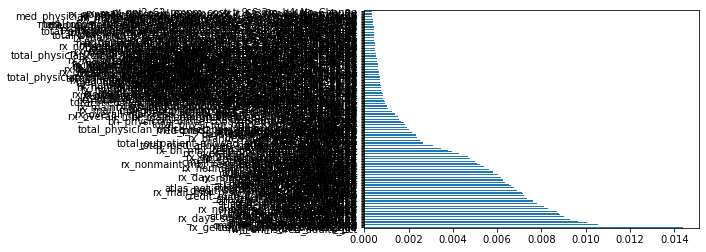

In [782]:
X_1 = X_train_final #independent columns
y_1 = y_train   #target column
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
model = DecisionTreeClassifier()
model.fit(X_1,y_1)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_1.columns)
feat_importances.nlargest(300).plot(kind='barh')
plt.show()

filter_mask = [ a > 0.002 for a in  model.feature_importances_]

In [783]:
X_train_final_filtered = X_train_final[X_train_final.columns[filter_mask]]

In [784]:
X_train_final_filtered

,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,cons_chmi,cons_ltmedicr,atlas_pc_snapben15,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,rx_bh_pmpm_ct_0to3m_b4,...,atlas_avghhsize,atlas_ownhomepct,atlas_orchard_farms12,atlas_pct_fmrkt_wic16,rwjf_social_associate_rate,atlas_freshveg_farms12,days_since_last_clm_0to3m_b4,cons_lwcm07,atlas_pct_fmrkt_otherfood16,atlas_pct_laccess_white15
357303,0.225918,1.194997,1.201564,-1.574606,0.343095,0.620767,-1.663172,-0.146301,-0.076311,-0.427363,...,0.887618,0.578265,-0.209309,-0.507646,0.536260,-0.659142,0.794692,-0.035100,1.304520,0.648903
71722,-0.333869,0.061182,1.201564,-0.935822,-0.820610,0.209440,-0.775907,-0.146301,0.349224,1.644213,...,-1.059431,0.049450,-0.141360,-0.507646,0.968599,-0.164569,0.794692,0.777624,1.304520,-0.212994
16147,-0.906545,0.520971,0.533006,-1.615858,0.730997,1.032093,-1.026586,0.040497,-0.122747,-0.427363,...,0.257691,0.186013,-0.158347,-0.507646,-0.347527,-0.329426,0.794692,-0.528716,0.686904,-0.601608
707251,0.239518,2.613838,0.198726,-0.063754,1.401009,-0.613214,-0.978284,-0.146301,-0.055767,-0.427363,...,0.085892,0.793082,-0.186659,-0.507646,-0.488992,-0.263483,0.794692,-0.191921,-0.239521,1.459698
448354,-1.626716,-0.945959,1.201564,-0.762991,-0.362180,0.620767,0.197048,-0.146301,-0.128728,1.126319,...,-0.429503,1.884710,-0.062085,1.923291,0.651312,0.033261,-1.373449,0.748575,1.304520,-0.972402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344962,-1.259864,0.133183,1.201564,0.628445,-0.503235,0.209440,-1.673291,-0.146301,-0.156199,2.680000,...,-1.002165,0.864782,-0.141360,-0.507646,0.281723,0.956464,-1.439150,-1.008932,1.304520,-1.685221
7171,-0.162648,-0.561327,0.819531,-0.763867,0.977844,0.209440,-0.831151,-0.146301,-0.126733,-0.427363,...,-0.601302,0.139704,-0.124372,0.794642,-0.882973,0.593777,0.794692,0.445116,0.532500,1.158208
902534,-1.223402,0.095061,-0.135553,1.328992,-0.961665,0.209440,1.257845,-0.146301,-0.198227,-0.427363,...,0.372223,-1.565012,-0.152684,-0.212987,-1.048458,-0.065654,-0.563133,3.598574,0.013141,-1.186836
884042,0.626646,0.086493,-0.013997,0.671707,2.106285,-0.201887,0.307330,-0.146301,-0.061322,-0.427363,...,0.028626,-0.108947,-0.186659,2.193396,-0.096797,-0.428341,0.794692,-1.545424,0.275160,-0.525167


### Fitting into different models

In [785]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC


In [786]:
# Init, fit
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=3000, class_weight='balanced'),

    step=3,
    n_jobs=-1,
    scoring="r2",
    cv=5,
    verbose=True
)

In [787]:
selector = rfecv.fit(X_train_final_filtered, y_train)

Fitting estimator with 136 features.
Fitting estimator with 133 features.
Fitting estimator with 130 features.
Fitting estimator with 127 features.
Fitting estimator with 124 features.
Fitting estimator with 121 features.
Fitting estimator with 118 features.
Fitting estimator with 115 features.


In [788]:
xtest = transformed_X(X_test)

In [789]:
xtest = xtest[X_train_final_filtered.columns]

In [790]:
pred = rfecv.predict(xtest)

In [791]:
from sklearn.metrics import classification_report, confusion_matrix

In [792]:
confusion_matrix(y_test, pred)

array([[16790, 10416],
       [ 2317,  3477]])

## Transforming and Finding Most Relevant Columns

In [610]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC


In [612]:
# Init, fit
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=5000, class_weight='balanced'),
    min_features_to_select=15,
    step=5,
    n_jobs=-1,
    scoring="r2",
    cv=5,
    verbose=True
)

In [613]:
# svc = LinearSVC() #estimator
# rfecv = RFECV(estimator=svc, scoring='accuracy')


In [614]:
X_train_final.index

Int64Index([357303,  71722,  16147, 707251, 448354,  97566, 625059,  24137,
            469856, 203081,
            ...
            761443, 966219, 454398, 231923, 842517, 344962,   7171, 902534,
            884042, 245102],
           dtype='int64', length=52334)

In [615]:
y_train.index

Int64Index([357303,  71722,  16147, 707251, 448354,  97566, 625059,  24137,
            469856, 203081,
            ...
            761443, 966219, 454398, 231923, 842517, 344962,   7171, 902534,
            884042, 245102],
           dtype='int64', length=52334)

In [669]:
# set the y_train
y_train = y_train.loc[X_train_final.index]
y_train

357303    0
71722     0
16147     0
707251    0
448354    0
         ..
344962    0
7171      0
902534    0
884042    0
245102    0
Length: 52334, dtype: int8

In [617]:
selector = rfecv.fit(X_train_final, y_train)

Fitting estimator with 746 features.
Fitting estimator with 741 features.
Fitting estimator with 736 features.
Fitting estimator with 731 features.
Fitting estimator with 726 features.
Fitting estimator with 721 features.
Fitting estimator with 716 features.
Fitting estimator with 711 features.
Fitting estimator with 706 features.
Fitting estimator with 701 features.
Fitting estimator with 696 features.
Fitting estimator with 691 features.
Fitting estimator with 686 features.
Fitting estimator with 681 features.
Fitting estimator with 676 features.
Fitting estimator with 671 features.
Fitting estimator with 666 features.
Fitting estimator with 661 features.
Fitting estimator with 656 features.
Fitting estimator with 651 features.


In [619]:
X_train_final_trimmed = X_train_final.columns[rfecv.support_]

In [620]:
X_train_final_trimmed

Index(['atlas_recfacpth14', 'atlas_pct_fmrkt_frveg16',
       'atlas_pct_free_lunch14', 'src_div_id', 'cons_chmi', 'cons_ltmedicr',
       'rx_gpi4_6110_pmpm_ct', 'atlas_pc_snapben15',
       'rx_bh_mbr_resp_pmpm_cost_9to12m_b4', 'atlas_pct_laccess_nhna15',
       ...
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_over_8x',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_over_8x',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_New',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No Activity',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change',
       'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved'],
      dtype='object', length=646)

In [696]:
rfecv.predict_proba()

TypeError: predict_proba() missing 1 required positional argument: 'X'

### Wrapping using embedded techniques

In [674]:
from sklearn.linear_model import LassoCV
# import lasso with cross validation
lassoModel = LassoCV(cv=3).fit(X_train_final,y_train)

### Packet all transformations in a single method

In [659]:
def transformed_X(xtest):
    
    xtest = xtest.replace('*', np.nan)
    
    # numerical
    xt = xtest[X_cols].copy()
    
    xt.fillna(X_train_num.median(), inplace=True)
#     print(xt.isna().sum().sort_values())
    xt = pd.DataFrame(scaler.transform(xt),
                                          index = xt.index,
                                          columns = xt.columns)
    
    xt = xt[X_train_num_imputed_scaled.columns]
#     print(xt.shape)
#     print(X_train_num_imputed_scaled.shape)
    
    # categorical + dummify columns 
    xcat = xtest[X_train_cat.columns].copy()
    xcat = pd.get_dummies(xcat, prefix=xcat.columns)
    xcat = xcat[X_train_cat_dummified.columns]
    
#     print(xcat.shape)
#     print(X_train_cat_dummified.shape)

    
    x_final = pd.merge(xt, xcat, left_index=True, right_index=True)
    
    return x_final
    

In [660]:
transformed_X(X_test)

,auth_3mth_post_acute_dia,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,src_div_id,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,cons_chmi,...,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Resolved,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_1x-2x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_2x-4x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_4x-8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc_over_8x,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved
431141,0.0,-0.506233,-0.664740,0.533006,2.909540,0.0,0.0,-0.277275,0.0,-0.961665,...,0,0,0,0,0,0,0,0,1,0
631027,0.0,0.774851,1.311510,-0.135553,-0.488906,0.0,0.0,2.589419,0.0,1.965230,...,0,0,0,0,0,0,0,0,0,0
325892,0.0,0.180621,-0.736416,-0.469832,-0.038409,0.0,0.0,-0.277275,0.0,1.048371,...,0,0,0,0,0,0,0,0,0,0
922416,0.0,-0.177599,-1.911968,0.087300,0.350495,0.0,0.0,-0.277275,0.0,-0.221125,...,1,0,0,0,0,0,0,0,0,0
768946,0.0,-0.222114,-0.144842,0.087300,-0.369756,0.0,0.0,-0.277275,0.0,-0.820610,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204515,0.0,2.014944,-1.911968,0.087300,1.439274,0.0,0.0,-0.277275,0.0,-0.080070,...,0,0,0,0,0,0,0,0,0,0
297150,0.0,0.736186,0.141572,-0.284121,0.515171,0.0,0.0,-0.277275,0.0,-1.737468,...,0,0,0,0,0,0,0,0,1,0
956033,0.0,1.235578,-1.050977,-2.141228,0.812825,0.0,0.0,-0.277275,0.0,-0.891137,...,1,0,0,0,0,0,0,0,0,0
546107,0.0,-0.171216,1.002003,-1.026964,-0.393545,0.0,0.0,-0.277275,0.0,-0.080070,...,0,0,0,0,0,0,0,0,0,0


### Select top columns

[0.00000000e+00 4.00429325e-03 3.90910948e-03 3.65484762e-03
 3.83253248e-03 0.00000000e+00 0.00000000e+00 2.23862762e-03
 0.00000000e+00 4.53810800e-03 0.00000000e+00 0.00000000e+00
 4.51703097e-03 3.72644247e-04 3.94431523e-03 2.73368775e-03
 3.86515069e-03 0.00000000e+00 3.02506789e-03 0.00000000e+00
 3.98458332e-03 0.00000000e+00 3.87126380e-03 3.74746620e-03
 4.16850456e-03 1.55247093e-03 3.82259007e-03 1.87537896e-03
 4.14205755e-03 3.86338120e-03 3.71371354e-03 3.41564626e-03
 1.80242531e-03 3.71643053e-03 7.25704409e-04 0.00000000e+00
 0.00000000e+00 3.88595213e-03 6.53684125e-05 3.71684834e-03
 3.84045347e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.21811577e-03 5.93203636e-05 3.96913881e-03 1.05465267e-06
 4.29393904e-03 3.33681732e-03 0.00000000e+00 0.00000000e+00
 3.73523978e-03 1.38984054e-03 2.62774792e-05 0.00000000e+00
 3.67566501e-03 3.78000915e-03 0.00000000e+00 3.86126844e-03
 3.96350894e-03 2.81340436e-03 1.29670586e-05 3.84766487e-03
 4.67067803e-03 3.537488

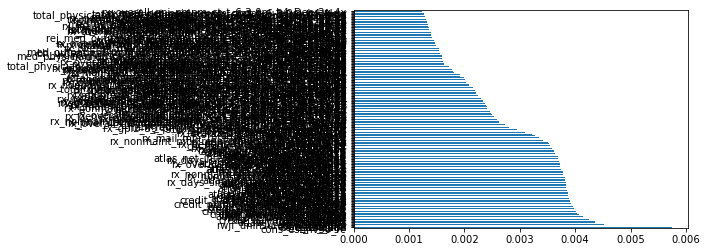

In [718]:
aaa = X_1[X_1.columns[filter_mask]]

In [719]:
aaa

,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,cons_chmi,cons_ltmedicr,atlas_pc_snapben15,atlas_pct_laccess_nhna15,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,...,atlas_orchard_farms12,rx_gpi2_33_pmpm_ct_0to3m_b4,rwjf_social_associate_rate,atlas_freshveg_farms12,cons_lwcm07,atlas_pct_fmrkt_otherfood16,atlas_pct_laccess_white15,cons_mobplus_S,sex_cd_M,cons_hhcomp_B
357303,0.225918,1.194997,1.201564,-1.574606,0.343095,0.620767,-1.663172,-0.076311,-0.427363,-0.984069,...,-0.209309,1.007548,0.536260,-0.659142,-0.035100,1.304520,0.648903,0,0,1
71722,-0.333869,0.061182,1.201564,-0.935822,-0.820610,0.209440,-0.775907,0.349224,1.644213,0.835458,...,-0.141360,2.506177,0.968599,-0.164569,0.777624,1.304520,-0.212994,0,1,0
16147,-0.906545,0.520971,0.533006,-1.615858,0.730997,1.032093,-1.026586,-0.122747,-0.427363,-0.668948,...,-0.158347,-0.491081,-0.347527,-0.329426,-0.528716,0.686904,-0.601608,0,0,1
707251,0.239518,2.613838,0.198726,-0.063754,1.401009,-0.613214,-0.978284,-0.055767,-0.427363,0.224528,...,-0.186659,-0.491081,-0.488992,-0.263483,-0.191921,-0.239521,1.459698,0,0,1
448354,-1.626716,-0.945959,1.201564,-0.762991,-0.362180,0.620767,0.197048,-0.128728,1.126319,-0.789939,...,-0.062085,-0.491081,0.651312,0.033261,0.748575,1.304520,-0.972402,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344962,-1.259864,0.133183,1.201564,0.628445,-0.503235,0.209440,-1.673291,-0.156199,2.680000,0.215997,...,-0.141360,-0.491081,0.281723,0.956464,-1.008932,1.304520,-1.685221,1,0,0
7171,-0.162648,-0.561327,0.819531,-0.763867,0.977844,0.209440,-0.831151,-0.126733,-0.427363,-0.292400,...,-0.124372,-0.491081,-0.882973,0.593777,0.445116,0.532500,1.158208,0,1,0
902534,-1.223402,0.095061,-0.135553,1.328992,-0.961665,0.209440,1.257845,-0.198227,-0.427363,0.317521,...,-0.152684,-0.491081,-1.048458,-0.065654,3.598574,0.013141,-1.186836,0,0,0
884042,0.626646,0.086493,-0.013997,0.671707,2.106285,-0.201887,0.307330,-0.061322,-0.427363,-1.307798,...,-0.186659,1.007548,-0.096797,-0.428341,-1.545424,0.275160,-0.525167,1,0,0


In [299]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR

# estimator = SVR(kernel="linear")
# selector = RFECV(estimator, step=5, cv=5, verbose=True)
# selector = selector.fit(X_train_num_imputed_scaled[:1000], y_train[:1000])
# selector.support_

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Init, fit, test Lasso Regressor
forest = RandomForestRegressor(n_estimators=80)
_ = forest.fit(X_train_num_imputed_scaled[:10000], y_train[:10000])
forest.score(X_train_num_imputed_scaled[:10000], y_train[:10000])

1.0

In [62]:
fimp = pd.DataFrame(
    zip(X_train_num_imputed_scaled.columns, abs(forest.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight").reset_index(drop=True)

In [63]:
features = fimp[fimp['weight'] > 0.0085].feature

In [64]:
for f in features:
    print(f'{f} === {whatis(f)}\n\n')

met_obe_diag_pct === percentage of medical claims related to obesity in the past one year {Based on metabolic syndrome}


cms_partd_ra_factor_amt === Medicare Part D Risk Adjustment Factor Amount


atlas_berry_farms12 === Berry farms


atlas_redemp_snaps16 === SNAP redemptions/SNAP-authorized stores


atlas_pct_reduced_lunch14 === Students eligible for reduced-price lunch


rwjf_mv_deaths_rate === Health Behaviors - Motor vehicle crash deaths


atlas_deep_pov_children === Deep poverty for children


atlas_veg_acrespth12 === Vegetable acres harvested/1,000 pop


est_age === Member age {calculated using est_bday, relative to score/index date}


atlas_avghhsize === Average household size


rwjf_income_inequ_ratio === Social and Economic Factors - Ratio of household income at the 80th percentile to income at the 20th percentile


rx_nonmaint_mbr_resp_pmpm_cost === member reponsible cost per month of prescriptions related to non maintenance drugs in the past one year


atlas_ghveg_sqftpth12

### Rough

In [137]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


In [652]:
# Init, fit
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=5000, class_weight='balanced'),
    min_features_to_select=15,
    step=5,
    n_jobs=-1,
    scoring="r2",
    cv=5,
    verbose=True
)


In [661]:
selector = rfecv.fit(X_train_final[:5000], y_train[:5000])

Fitting estimator with 698 features.
Fitting estimator with 693 features.
Fitting estimator with 688 features.
Fitting estimator with 683 features.
Fitting estimator with 678 features.
Fitting estimator with 673 features.
Fitting estimator with 668 features.
Fitting estimator with 663 features.
Fitting estimator with 658 features.
Fitting estimator with 653 features.
Fitting estimator with 648 features.
Fitting estimator with 643 features.
Fitting estimator with 638 features.
Fitting estimator with 633 features.
Fitting estimator with 628 features.
Fitting estimator with 623 features.
Fitting estimator with 618 features.
Fitting estimator with 613 features.
Fitting estimator with 608 features.
Fitting estimator with 603 features.
Fitting estimator with 598 features.
Fitting estimator with 593 features.
Fitting estimator with 588 features.
Fitting estimator with 583 features.
Fitting estimator with 578 features.
Fitting estimator with 573 features.
Fitting estimator with 568 features.
F

In [662]:
fimp2 = X_train_final.columns[rfecv.support_]

In [663]:
feature_ranks = []
for i,j in enumerate(selector.ranking_):
    feature_ranks.append((j, X_train_final.columns[i]))
sorted_feature_ranks = sorted(feature_ranks, key= lambda x: x[0])
len(feature_ranks)

698

In [665]:
xtest = transformed_X(X_test)
# print(xtest.shape)
# print(X_train_num_imputed_scaled.sh)
probs = rfecv.predict_proba(xtest)

In [667]:
top20 = [i[1] for i in sorted_feature_ranks[:100]]
top20

['atlas_pct_laccess_child15',
 'atlas_recfacpth14',
 'rx_gpi4_6110_pmpm_ct',
 'atlas_pct_laccess_nhna15',
 'rx_bh_pmpm_ct_0to3m_b4',
 'cons_lwcm10',
 'atlas_ghveg_farms12',
 'cons_cwht',
 'atlas_retirement_destination_2015_upda',
 'ccsp_236_pct',
 'atlas_pct_laccess_hisp15',
 'auth_3mth_dc_no_ref',
 'atlas_pct_laccess_hhnv15',
 'atlas_hiamenity',
 'auth_3mth_bh_acute',
 'rwjf_uninsured_pct',
 'atlas_pct_wic15',
 'rx_nonmaint_mbr_resp_pmpm_cost',
 'atlas_veg_farms12',
 'atlas_vlfoodsec_13_15',
 'rx_gpi2_34_dist_gpi6_pmpm_ct',
 'est_age',
 'cnt_cp_webstatement_pmpm_ct',
 'phy_em_px_pct',
 'atlas_percapitainc',
 'rwjf_uninsured_adults_pct',
 'rwjf_air_pollute_density',
 'atlas_pct_obese_adults13',
 'rev_pm_obsrm_pmpm_ct',
 'total_physician_office_net_paid_pmpm_cost_9to12m_b4',
 'med_ip_snf_admit_days_pmpm',
 'cms_tot_partd_payment_amt',
 'rx_nonmaint_pmpm_ct',
 'cons_stlnindx',
 'atlas_hipov_1115',
 'atlas_redemp_snaps16',
 'rev_cms_ct_pmpm_ct',
 'total_physician_office_copay_pmpm_cost',


In [671]:
lr = LogisticRegression(max_iter=5000, class_weight='balanced')
_ = lr.fit(X_train_final[top20], y_train)

print("Training R-sqaured:", lr.score(X_train_final[top20], y_train))

Training R-sqaured: 0.5775977376084381


In [216]:
s2 = set(fimp2.values.tolist())

In [217]:
s1 = set(features.values.tolist())

In [218]:
s1.union(s2)

{'atlas_agritrsm_rct12',
 'atlas_avghhsize',
 'atlas_berry_acrespth12',
 'atlas_berry_farms12',
 'atlas_convspth14',
 'atlas_csa12',
 'atlas_deep_pov_all',
 'atlas_deep_pov_children',
 'atlas_dirsales_farms12',
 'atlas_farm_to_school13',
 'atlas_fmrktpth16',
 'atlas_foodhub16',
 'atlas_foodinsec_child_03_11',
 'atlas_freshveg_farms12',
 'atlas_fsrpth14',
 'atlas_ghveg_farms12',
 'atlas_ghveg_sqftpth12',
 'atlas_grocpth14',
 'atlas_hh65plusalonepct',
 'atlas_hiamenity',
 'atlas_hipov_1115',
 'atlas_low_education_2015_update',
 'atlas_low_employment_2015_update',
 'atlas_medhhinc',
 'atlas_net_international_migration_rate',
 'atlas_orchard_acrespth12',
 'atlas_orchard_farms12',
 'atlas_ownhomepct',
 'atlas_pc_dirsales12',
 'atlas_pc_ffrsales12',
 'atlas_pc_fsrsales12',
 'atlas_pc_snapben15',
 'atlas_pc_wic_redemp12',
 'atlas_pct_cacfp15',
 'atlas_pct_diabetes_adults13',
 'atlas_pct_fmrkt_anmlprod16',
 'atlas_pct_fmrkt_credit16',
 'atlas_pct_fmrkt_frveg16',
 'atlas_pct_fmrkt_otherfood16',

In [219]:
s2

{'atlas_agritrsm_rct12',
 'atlas_avghhsize',
 'atlas_berry_acrespth12',
 'atlas_berry_farms12',
 'atlas_convspth14',
 'atlas_csa12',
 'atlas_deep_pov_all',
 'atlas_dirsales_farms12',
 'atlas_farm_to_school13',
 'atlas_fmrktpth16',
 'atlas_foodhub16',
 'atlas_foodinsec_child_03_11',
 'atlas_freshveg_farms12',
 'atlas_fsrpth14',
 'atlas_ghveg_farms12',
 'atlas_ghveg_sqftpth12',
 'atlas_grocpth14',
 'atlas_hh65plusalonepct',
 'atlas_hiamenity',
 'atlas_hipov_1115',
 'atlas_low_education_2015_update',
 'atlas_low_employment_2015_update',
 'atlas_medhhinc',
 'atlas_net_international_migration_rate',
 'atlas_orchard_acrespth12',
 'atlas_orchard_farms12',
 'atlas_ownhomepct',
 'atlas_pc_dirsales12',
 'atlas_pc_ffrsales12',
 'atlas_pc_fsrsales12',
 'atlas_pc_snapben15',
 'atlas_pc_wic_redemp12',
 'atlas_pct_cacfp15',
 'atlas_pct_diabetes_adults13',
 'atlas_pct_fmrkt_anmlprod16',
 'atlas_pct_fmrkt_credit16',
 'atlas_pct_fmrkt_frveg16',
 'atlas_pct_fmrkt_otherfood16',
 'atlas_pct_fmrkt_sfmnp16',

In [220]:
xtest = X_test.copy()

In [221]:
xtest

,ID,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,...,auth_3mth_post_acute_end,auth_3mth_acute_mus,atlas_perpov_1980_0711,atlas_pct_laccess_white15,auth_3mth_post_acute_mean_los,rx_gpi2_66_pmpm_ct,auth_3mth_acute_gus,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd
431141,aMOS65TLa0569YacdA38I56a,0,5.766666,3.652522,0.059461,80.000000,91.104503,0.0,0,0.0,...,0,0,0.0,8.453037,0.0,0.000000,0,No_Change,0.0,1.0
631027,425Mcac1O8bScT7dL6Y7AI96,0,0.000000,7.086245,0.153677,60.000000,38.730708,0.0,0,0.0,...,0,0,0.0,26.610935,0.0,0.000000,0,Dec_1x-2x,0.0,1.0
325892,fM0aaOSaT0f2La64Y42AebaI,0,4.050000,5.493512,0.056044,50.000000,NaN,NaN,0,0.0,...,0,0,0.0,21.979738,0.0,0.500000,0,Dec_1x-2x,0.0,1.0
922416,eMO61SdfTLa616705dYAIe9d,0,0.000000,4.533366,0.000000,NaN,51.666802,0.0,0,0.0,...,0,0,0.0,27.631187,0.0,0.000000,0,Dec_1x-2x,0.0,1.0
768946,1M87OS6TLY70Afbe23c5Ifeb,0,0.000000,4.414051,0.084246,66.666667,40.566942,0.0,0,0.0,...,0,0,0.0,19.820315,0.0,0.000000,0,No Activity,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204515,8cMO57S6TLaYa80b6A4074fI,0,0.000000,10.410097,0.000000,NaN,68.446087,NaN,0,0.0,...,0,0,1.0,6.429235,0.0,0.000000,0,No Activity,1.0,1.0
297150,MOSTL6Yaef6528fA4bd3Iab5,0,0.000000,6.982609,0.097901,55.555556,54.204627,0.0,0,0.0,...,0,0,0.0,6.473853,0.0,0.000000,0,No_Change,0.0,1.0
956033,7c875MO2da6Sc9TLYcAIaa26,0,0.000000,8.321143,0.041047,0.000000,58.791805,0.0,0,0.0,...,0,0,0.0,3.152018,0.0,0.000000,0,Dec_1x-2x,0.0,1.0
546107,M1O9f1ST07485Le0YAbI6822,0,0.000000,4.550475,0.138921,33.333333,40.200313,0.0,0,0.0,...,0,0,0.0,21.887865,0.0,0.416667,0,New,0.0,1.0


In [286]:
xtest = transformed_X(xtest)

rx_gpi2_72_pmpm_cost_6to9m_b4      0
rx_nonbh_pmpm_ct_0to3m_b4          0
atlas_pc_ffrsales12                0
credit_bal_bankcard_severederog    0
atlas_povertyunder18pct            0
                                  ..
auth_3mth_acute_ccs_172            0
credit_num_agencyfirstmtg          0
auth_3mth_acute_ccs_154            0
auth_3mth_post_acute_dig           0
race_cd                            0
Length: 252, dtype: int64


In [672]:
print("Training R-sqaured:", lr.score(xtest[top20], y_test))

Training R-sqaured: 0.6040909090909091


In [290]:
from sklearn.metrics import classification_report, confusion_matrix

In [291]:
lr.predict_proba(xtest[top20][:10000])

array([[0.74093325, 0.25906675],
       [0.80798753, 0.19201247],
       [0.61889046, 0.38110954],
       ...,
       [0.72064387, 0.27935613],
       [0.56736789, 0.43263211],
       [0.68426982, 0.31573018]])

,Feature 1,Feature 2,Correlation (abs)
217,rx_gpi2_34_pmpm_ct,rx_gpi4_3400_pmpm_ct,0.987196
219,bh_ncal_pct,bh_ncal_ind,0.979503
221,bh_ncdm_ind,bh_ncdm_pct,0.973015
223,rx_overall_gpi_pmpm_ct_0to3m_b4,rx_generic_pmpm_ct_0to3m_b4,0.964032
225,rx_nonbh_mbr_resp_pmpm_cost,rx_overall_mbr_resp_pmpm_cost,0.959609
...,...,...,...
63492,race_cd,auth_3mth_acute_ccs_043,NaN
63494,race_cd,auth_3mth_acute_ccs_094,NaN
63496,race_cd,auth_3mth_acute_ccs_044,NaN
63498,race_cd,auth_3mth_post_acute_ner,NaN


In [596]:
data_100k.covid_vaccination.value_counts()

no_vacc    82438
vacc       17562
Name: covid_vaccination, dtype: int64

In [600]:
print(len(X_train_final.columns))

746
